<a href="https://colab.research.google.com/github/MarkStephens060482/Beijing-Air-Quality/blob/main/Assignment_2_RF_model_book_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Foundations of Computer Science - Python B
### Mark Stephens - a1847018

# Beijing Multi-Site Air Quality dataset

The data set considers hourly observations of 6 main air pollutants and 6 relevant meteorological variables at multiple sites in Beijing over a 5 year period. The data is recorded by 12 nationally-controlled air-quality monitoring sites.

<center>
<h2> The Data </h2>
    
The data used in this project was sourced from Machine Learning Repository, https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data. The dataset contains daily weather information of temperature, pressure, dewpoint, precipitation, wind direction and wind speed. The data set has undergone preprocessing of missing value imputation, removeal of outliers and some variable transformation.

***
***
## Loading the cleaned data set
The preprocessed data set is loaded.

In [ ]:
# importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob

#_________The data files are to be loaded into current working directory___________
# Get the current working directory
cwd = os.getcwd()

file = cwd + '\clean_beijing_df.csv'

with open(file,encoding="utf-8") as dataFile:
        beijing_df = pd.read_csv(dataFile,index_col=0)
# view the dataframe
beijing_df.head()


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd,station,weekend
0,2013,3,1,0,4.0,4.0,4.0,7.000000,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,NNW,Aotizhongxin,no
1,2013,3,1,0,3.0,6.0,13.0,7.000000,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5,E,Changping,no
2,2013,3,1,0,4.0,4.0,3.0,3.997836,200.0,82.0,-2.3,1020.8,-19.7,0.0,0.5,E,Dingling,no
3,2013,3,1,0,9.0,9.0,3.0,17.000000,300.0,89.0,-0.5,1024.5,-21.4,0.0,5.7,NNW,Dongsi,no
4,2013,3,1,0,4.0,4.0,14.0,20.000000,300.0,69.0,-0.7,1023.0,-18.8,0.0,4.4,NNW,Guanyuan,no


### Random Forest Regression
The preprocessing steps to use for Random Forest Regression are as follows:
1. drop unwanted features
2. Convert categorical features with an ordinal encoder.

#### Feature selection 
The following are the features to be excluded from the model:
1. **year**
2. **PM10**
All other features can be includes as the ensemble method randomly selects features itself.

#### Convert Categorical variable
The categorical variable will be ordinal encoded instead of One Hot encoded to keep the number of features reduced and in turn ensure max depth isn't required to be be too large, to reduce process time.


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline 
from sklearn.ensemble import RandomForestRegressor
# list of unwanted features for Multi-Layer Perception Regressor
drop_features = ['year', 'PM10']

#list of selected categorical features
cat_features = ['weekend', 'station','wd']

#initialise One Hot encoder
ord_enc = OrdinalEncoder()

#define column transformer to drop particular columns and Ordinal encode nominal variables, 
#ordinal encoder defined previously.
preprocessor_rf = make_column_transformer(
    ('drop',drop_features),
    (ord_enc,cat_features),
    remainder="passthrough")

#initialise the Random Forest Regressor
regressor_rf = RandomForestRegressor(n_jobs = -1,
                                     random_state = 20)

#define the Random Forest Regressor pipeline

pipeline_rf = make_pipeline(preprocessor_rf,regressor_rf)

#### Dummy Regressor
Use a 'mean' strategy to establish a baseline for model performance.

In [ ]:
from sklearn.dummy import DummyRegressor
# initiialise the dummy regressor
regressor_dummy = DummyRegressor(strategy='mean')
#develop a pipeline model for the dummy regressor
pipeline_dummy = make_pipeline(regressor_dummy)

***
### Data Segregation
The cleaned dataset *beijing_df* is seperated into predictors and target variable and then split into a training and test datasets. 
A k-Fold Cross Validation splitting method is defined. Due to computational constraints in handling the size of the data, a random sample is used to fit the model. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

sample_frac = 0.15
#Random sample of observation.
beijing_sample = beijing_df.sample(frac = sample_frac)

# seperate variables into features (X)  and target (y) .
X = beijing_sample.drop(columns = 'PM2.5')
y = beijing_sample['PM2.5']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

new_line = '\n'
print(f'Training dataset:{new_line}\
X_train = { X_train.shape} {new_line}\
y_train = { y_train.shape}{new_line}')

print(f'Testing dataset:{new_line}\
X_test = {X_test.shape}{new_line}\
y_test = {y_test.shape}')

# initialise the Cross-validation strategy
n_splits = 5
#n_repeats = 3
splitter = KFold(n_splits = n_splits, shuffle = True, random_state=20)


Training dataset:
X_train = (48766, 17) 
y_train = (48766,)

Testing dataset:
X_test = (12192, 17)
y_test = (12192,)


***
### Model fitting and Hyper parameter tuning
Both the untuned and tuned models are to be evaluated using cross validation

#### Evaluating the untuned model using cross validation
The models are looped through and the mean value and standard error of the scoring metrics of RMSE and MSE are determined under cross-validation.

In [ ]:
from sklearn.model_selection import cross_validate

# define of estimators including the dummy regressor
pipelines = [pipeline_dummy,pipeline_rf]

scoring = ['neg_root_mean_squared_error', 'neg_mean_squared_error','r2']

model_scores1 = []
model_scores2 = []
model_scores3 = []
# loop over the model pipelines
for pipe in pipelines:
    
    # perform cross validation to get cv performance scores
    cv_results = cross_validate(pipe,X_train,
                                y_train,
                                scoring = scoring,
                                cv = splitter,
                                verbose = 3,
                               n_jobs = -1)
    
    # determine mean and standard deviation of cv performance RMSE
    mean_RMSE = -1*cv_results['test_neg_root_mean_squared_error'].mean() 
    stdev_RMSE = cv_results['test_neg_root_mean_squared_error'].std()
    
     # determine mean and standard deviation of cv performance MSE
    mean_MSE = -1*cv_results['test_neg_mean_squared_error'].mean() 
    stdev_MSE = cv_results['test_neg_mean_squared_error'].std()
    
    # determine mean and standard deviation of cv performance r^2 score
    mean_r2 = cv_results['test_r2'].mean() 
    stdev_r2 = cv_results['test_r2'].std()
    
    # standard error of the Cross validation scores
    sterr_RMSE = stdev_RMSE/np.sqrt(n_splits)
    sterr_MSE = stdev_MSE/np.sqrt(n_splits)
    sterr_r2 = stdev_r2/np.sqrt(n_splits)
    
    # mean cross validationm scores with error
    score_RMSE = f'{mean_RMSE: .2f} \u00B1 {2*sterr_RMSE: .2f}'
    score_MSE = f'{mean_MSE: .2f} \u00B1 {2*sterr_MSE: .2f}'
    score_r2 = f'{mean_r2: .2f} \u00B1 {2*sterr_r2: .2f}'
    
    # append model name and cv score to list
    model_scores1.append(score_RMSE)
    model_scores2.append(score_MSE)
    model_scores3.append(score_r2)

# express as a Data Frame
results_df = pd.DataFrame(np.array([model_scores1,model_scores2,model_scores3]), 
                          columns = ["Dummy Regressor","Untuned RF Regressor"],
                          index = ['RMSE','MSE','r2'])
results_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   59.9s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


,Dummy Regressor,Untuned RF Regressor
RMSE,70.25 ± 0.73,27.67 ± 0.30
MSE,4935.70 ± 102.10,765.53 ± 16.75
r2,-0.00 ± 0.00,0.84 ± 0.00


It is noted that the untuned Random Forest regressor under cross-validation with 5 folds took 1.4 minutes, though achieving good performanced of 31 RMSE and R squared of 0.85. It is worth investigating reasonable ranges of hyperparameters to see if the model fit time can be reduced while still maintained reasonable performance scores.

#### Investigating reasonableness of hyperparameter tuning ranges.
The two hyperparameters to explore are the *n_estimators* and *max_depth* and their effect on computation time and cross-validation score. The random forest model is fitted for samples sizes of 2.5%, 5% and 10% of the dataset with incrementally increrasing values of the hyperparameters. Only one hyperparameter in changed at a time, maintaining the other as constant.  The computation time and CV score are recorded for each fit.

In [ ]:
# loop through different sizes of sample dataset

# Second hyperparameter experiment 
test2_results=[]
# first hyperparameter experiment
test1_results=[]

for i in range(1,4):
    # sample the data at smaller proportions: 2.5%, 5%, 10%. 
    test_sample_frac = 0.2/(2**(4-i))
    #Random sample of observation.
    test_data_sample = beijing_df.sample(frac = test_sample_frac)
     # seperate variables into features (X)  and target (y) .
    test_data_X = test_data_sample.drop(columns = 'PM2.5')
    test_data_y = test_data_sample['PM2.5']
    
    #loop through different values of hyper-parameters.
    for n in range(1,8):
        # Random Forest with number of trees of 2, 4, 8, 16, 32, 64,128
        n_trees = 2**n
        test_rf1 = RandomForestRegressor(n_estimators = n_trees,
                                        max_depth = 12,
                                        n_jobs = -1,
                                        random_state = 20)
        test_pipe1 =  make_pipeline(preprocessor_rf,test_rf1)
        # perform Cross-validation for standard splitter of 5 folds with shuffle
        test_cv_results1 = cross_validate(test_pipe1,
                                         test_data_X,
                                         test_data_y,
                                         cv = splitter,
                                         #verbose = 3,
                                         n_jobs = -1)
        # Calculate the Computation times
        total_time1 = test_cv_results1['fit_time'] + test_cv_results1['score_time']
        #Record the test data size, hyperparameter value, average computation time and average cv score
        test1_results.append([f'{test_sample_frac*100}%' ,
                              n_trees,
                              total_time1.mean(),
                              round(test_cv_results1['test_score'].mean(),3)])
    
    #loop through different values of hyper-parameters.
    for n in range(6):
        # Random Forest with max depth: 5, 7, 10, 15, 20, 25
        max_depth = [5 ,7, 10, 15, 20, 25]
        test_rf2 = RandomForestRegressor(n_estimators = 60,
                                        max_depth = max_depth[n],
                                        n_jobs = -1,
                                        random_state = 20)
        test_pipe2 =  make_pipeline(preprocessor_rf,test_rf2)
        # perform Cross-validation for standard splitter of 5 folds with shuffle
        test_cv_results2 = cross_validate(test_pipe2,
                                         test_data_X,
                                         test_data_y,
                                         cv = splitter,
                                         #verbose = 3,
                                         n_jobs = -1)
        total_time2 = test_cv_results2['fit_time'] + test_cv_results2['score_time']
        test2_results.append([f'{test_sample_frac*100}%',
                              max_depth[n],
                              total_time2.mean(),
                              round(test_cv_results2['test_score'].mean(),3)])


In [ ]:
testdata1 = pd.DataFrame(test1_results,
                         columns = ["sample_size",
                                    "n_estimator",
                                    "mean_computation_time",
                                    "mean_CV_score"])

testdata2 = pd.DataFrame(test2_results,
                         columns = ["sample_size",
                                    "max_depth",
                                    "mean_computation_time",
                                    "mean_CV_score"])

Visualisation of hyperparameter values with fitting time and R squared Cross validation score 

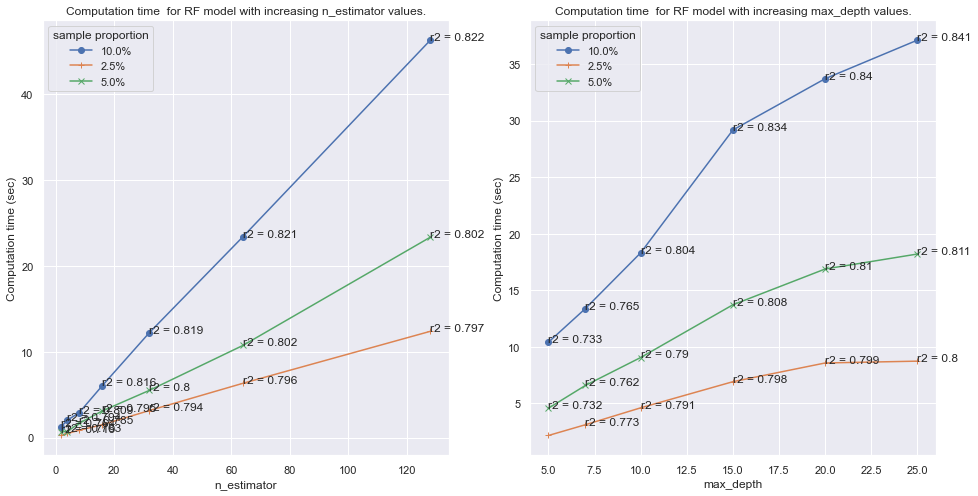

In [ ]:
import matplotlib.pyplot as plt
sns.set()

fig,axs = plt.subplots(1,2, figsize = (16,8))

markers = ['o','+','x']
groups1 = testdata1.groupby("sample_size")
# plot of n_estimates and computation time with CV score labels for different sample size
i = 0
for name1, group1 in groups1:
    axs[0].plot(group1.n_estimator,
                group1.mean_computation_time,
                marker = markers[i],
                label = name1)
    i+=1
axs[0].legend(title = "sample proportion")
axs[0].set(title = "Computation time  for RF model with increasing n_estimator values.",
          xlabel = "n_estimator",
          ylabel = "Computation time (sec)")

# label each point with the mean RMSE CV score 
for i, txt in enumerate(testdata1["mean_CV_score"]):
    if i < 4:
        continue   
    axs[0].annotate(f'r2 = {txt}', (testdata1["n_estimator"][i],
                                    testdata1["mean_computation_time"][i]))


groups2 = testdata2.groupby("sample_size")
# plot of max depth andf computation time with CV score labels for different sample size
j=0
for name2, group2 in groups2:
    axs[1].plot(group2.max_depth,
                group2.mean_computation_time,
                marker = markers[j],
                label = name2)
    j+=1
axs[1].legend(title = "sample proportion") 
axs[1].set(title = "Computation time  for RF model with increasing max_depth values.",
          xlabel = "max_depth",
          ylabel = "Computation time (sec)")
# label each point with the mean RMSE CV score 
for j, txt in enumerate(testdata2["mean_CV_score"]):
    if j < 1:
        continue
    axs[1].annotate(f'r2 = {txt}', (testdata2["max_depth"][j],
                                    testdata2["mean_computation_time"][j]))
    

#### Figure 12: Trend in computational time and CV score with increasing value of hyperparameters and sample size.
Computation time increases linearly with increases in n_estimator, where as no significant gain in the CV score is achieved for n_estimate values more than 40. The sample size also greatly affects computation time, with a doubling of sample size leading to a doubling of computation time. Increases in the max_depth hyperparameter delivers significant gains in the CV score up to a value of 20, such that further increases delivers further computation expensive with little to no gain in CV score. To achieve a r squared performance score in the vicinity 0.8 and ensure computation time are reasonable, a sample size of 10% will be used, and hyperparameter tuning with limiting n_estimate to no more than 40, with max_depth no more than 20.

In [ ]:
sample_frac = 0.10
#Random sample of observation.
beijing_sample = beijing_df.sample(frac = sample_frac)

# seperate variables into features (X)  and target (y) .
X = beijing_sample.drop(columns = 'PM2.5')
y = beijing_sample['PM2.5']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#### Hyper parameter tuning
The hyper parameters of each model are tuned using a hybrid approach of Randomised Search and Grid Search cross validation. The randomised search identifies a ball park value for the optimum hyper parameter, while the grid seach will conduct a finer search within a range of value about best parameters from the randomised search.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
import numpy as np

# Random Forest Regression
# Define the hyperparameter distribution for the random search
random_param_rf = {
    "randomforestregressor__n_estimators": randint(10,40),
    "randomforestregressor__max_depth": randint(10,20),
    "randomforestregressor__min_samples_split": randint(2, 10),
    "randomforestregressor__min_samples_leaf": randint(1, 10)}

# Conduct random search within the region of the optimal hyperparameters
random_search = RandomizedSearchCV(pipeline_rf, 
                                   random_param_rf,
                                   n_iter = 100, 
                                   cv = splitter,
                                   scoring = scoring,
                                   refit='neg_root_mean_squared_error',
                                   n_jobs = -1,
                                   verbose=3)
# fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters from the random search
best_random = random_search.best_params_

# define best hyperparameters from Randomsearchcv
best_n_estimators = best_random['randomforestregressor__n_estimators']

best_max_depth = best_random['randomforestregressor__max_depth']

best_min_samples_split = best_random['randomforestregressor__min_samples_split']

best_min_samples_leaf = best_random['randomforestregressor__min_samples_leaf']

new_line = '\n'
print(f'Best hyper parameters for Randomised search are: {new_line}\
{best_random}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyper parameters for Randomised search are: 
{'randomforestregressor__max_depth': 19, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 28}


The best hyperparameters from the Randomised search are used within grid search hyperparameter ranges. The width of the ranges are a few integers wide.

In [ ]:
# Define the hyperparameter grid for the grid search
grid_param_rf = {
    "randomforestregressor__n_estimators": best_n_estimators + np.arange(-3, 3, 1),
    "randomforestregressor__max_depth": best_max_depth + np.arange(-3,3,1),
    "randomforestregressor__min_samples_split": best_min_samples_split + np.arange(0,2,1),
    "randomforestregressor__min_samples_leaf": best_min_samples_leaf + np.arange(0,2,1)}

# Conduct grid search to identify the general region of the optimal hyperparameters
grid_search = GridSearchCV(pipeline_rf,
                           grid_param_rf,
                           cv=splitter,
                           n_jobs=-1,
                           verbose=3,
                           scoring = scoring,
                           refit='neg_root_mean_squared_error')

grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_grid = grid_search.best_params_

# Train the final model with the best hyperparameters from the hybrid grid-random search
rf_final = pipeline_rf.set_params(
    **{'randomforestregressor__n_estimators' : best_grid['randomforestregressor__n_estimators'],
       'randomforestregressor__max_depth' : best_grid['randomforestregressor__max_depth'],
       'randomforestregressor__min_samples_split' : best_grid['randomforestregressor__min_samples_split'],
       'randomforestregressor__min_samples_leaf' : best_grid['randomforestregressor__min_samples_leaf']})

#Fit the final model
rf_final.fit(X_train, y_train)

# best mean cross-validation RMSE score
mean_RMSE = round(
    -1*grid_search.best_score_,2)
    
# best mean cross-validation MSE score
mean_MSE = round(
    -1*grid_search.cv_results_['mean_test_neg_mean_squared_error'][grid_search.best_index_],2)

# best mean cross-validation r2 score
mean_r2 = round(
    grid_search.cv_results_['mean_test_r2'][grid_search.best_index_],2)

# standard error of mean cross-validation RMSE score
sterr_RMSE = round(
    (grid_search.cv_results_['std_test_neg_root_mean_squared_error'][grid_search.best_index_])/np.sqrt(n_splits),2)

 # standard error of mean cross-validation r2 score
sterr_r2 = round(
    (grid_search.cv_results_['std_test_r2'][grid_search.best_index_])/np.sqrt(n_splits),2)

# standard error of mean cross-validation MSE score
sterr_MSE = round(
    (grid_search.cv_results_['std_test_neg_mean_squared_error'][grid_search.best_index_])/np.sqrt(n_splits),2)

new_line = '\n'
print(f'Best hyper parameters after Randomised and Grid search are: {new_line}\
{best_grid}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyper parameters after Randomised and Grid search are: 
{'randomforestregressor__max_depth': 21, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 30}


Best parameters for tuned model

In [ ]:
#summary of evaluation metrics
results_df1 = results_df.join(pd.DataFrame([(str(mean_RMSE)+" \u00B1 "+str(2*sterr_RMSE)),
                              (str(mean_MSE)+" \u00B1 "+str(2*sterr_MSE)),
                              (str(mean_r2)+" \u00B1 "+str(2*sterr_r2))],
                             columns = ["Tuned RF Regressor"],
                             index = ['RMSE','MSE','r2']), how = "left")
results_df1

,Dummy Regressor,Untuned RF Regressor,Tuned RF Regressor
RMSE,70.25 ± 0.73,27.67 ± 0.30,28.83 ± 0.34
MSE,4935.70 ± 102.10,765.53 ± 16.75,831.44 ± 20.0
r2,-0.00 ± 0.00,0.84 ± 0.00,0.83 ± 0.0


### Model Evaluation
The final model is evaluated using the test data set. The performance metrics are observed and compared.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# predict on the test data set
y_rf_pred = rf_final.predict(X_test)

# Calculate Mean Squared error
MSE_test = round(mean_squared_error(y_test, y_rf_pred),2)
# Calculate Root Mean Squared Error
RMSE_test = round(np.sqrt(mean_squared_error(y_test, y_rf_pred)),2)
# Calculate r2 score
r2_test = round(r2_score(y_test, y_rf_pred),2)


results_df2=results_df1.join(pd.DataFrame([RMSE_test,MSE_test,r2_test],
                             columns = ["RF model performance on test data"], 
                             index = ["RMSE","MSE",'r2'])) 
results_df2

,Dummy Regressor,Untuned RF Regressor,Tuned RF Regressor,RF model performance on test data
RMSE,70.25 ± 0.73,27.67 ± 0.30,28.83 ± 0.34,28.33
MSE,4935.70 ± 102.10,765.53 ± 16.75,831.44 ± 20.0,802.69
r2,-0.00 ± 0.00,0.84 ± 0.00,0.83 ± 0.0,0.83


### Plot of Predicted against True values and Learning Curve Plot
This is a visualisation of cross-validation training and test scores for different set sizes, applied to the whole data set. The visualisation shows the effect of adding more samples during the training process.

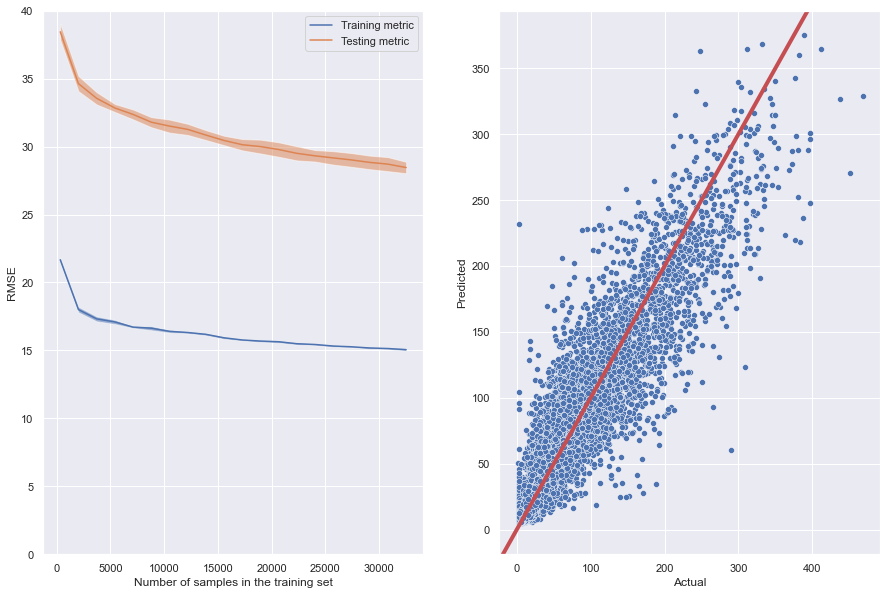

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay

fig,axs = plt.subplots(1,2, figsize = (15,10))

# Produce a Learning Curve Identifying training and test scores
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    rf_final,
    X, 
    y,
    train_sizes = np.linspace(0.01,1,20),
    return_times= True,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state = 20,
    cv = splitter)

display = LearningCurveDisplay(train_sizes=train_sizes,
                               train_scores=train_scores, 
                               test_scores=test_scores, 
                               score_name="RMSE")

display.plot(ax = axs[0],
            score_type='both',
            std_display_style='fill_between',
            negate_score=True)

axs[0].set_ylim(0,40)

pred_data = pd.DataFrame(np.c_[y_test, y_rf_pred], columns = ['Actual','Predicted'])
sns.scatterplot(data =pred_data,
                x = 'Actual',
                y = 'Predicted',
               ax = axs[1])

axs[1].axline((0, 0), slope=1,linewidth=4, color='r')


#### Figure 13: The learnig curve and predict vs actual plots of the Random Forest Regression model
The learning curve shows a decreasing trend in training and testing loss scores for increasing sample size, without a plateau. This suggests that the Random Forest is suffering from underfitting and is underperforming with the reduced dataset. It can benefit from being trained on a larger sample. The model can benefit from unconstrained hyperparameter tuning, although it is computationally expensive.

### Scalability of the model
The SVR model is fitted to a sample of the dataset a fraction of the size. If the model was to scale up to a larger amount of data, then the graphs below suggest the expected trend in computational times as more samples of data are added for model training. Also the trade off between increased fitting times and the cross validation score shows if up scaling a SVR model is worth doing.

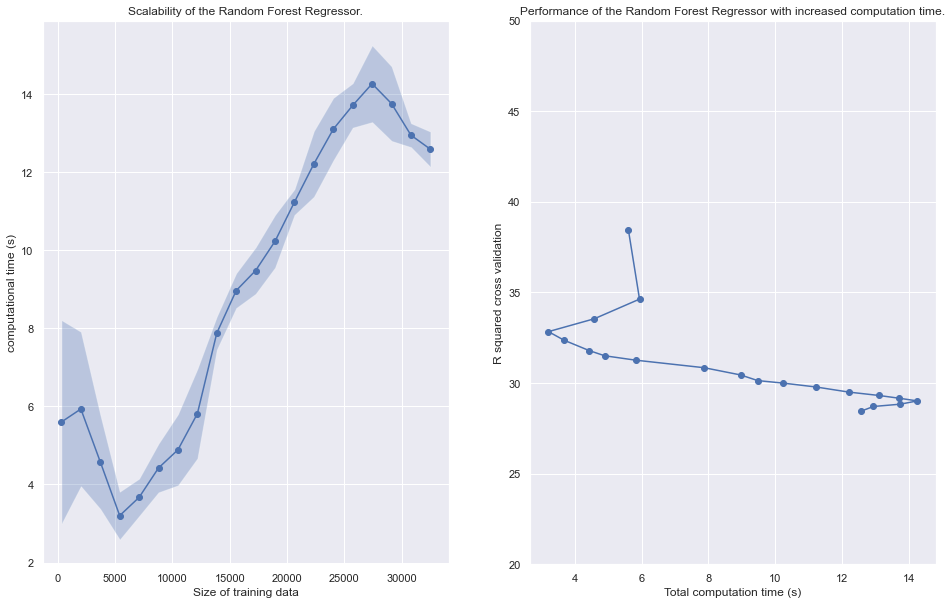

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

total_times = fit_times + score_times
# plots training size vs total computation time
axs[0].plot(train_sizes, total_times.mean(axis=1), "o-")
axs[0].fill_between(
        train_sizes,
        total_times.mean(axis=1) - total_times.std(axis=1),
        total_times.mean(axis=1) + total_times.std(axis=1),
        alpha=0.3)
axs[0].set_ylabel("computational time (s)")
axs[0].set_xlabel("Size of training data")
axs[0].set_title("Scalability of the Random Forest Regressor.")

# plots cross validation score with total computation time
axs[1].plot(total_times.mean(axis=1),-1* test_scores.mean(axis=1), "o-")
axs[1].fill_between(
        total_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3)
axs[1].set_ylabel("R squared cross validation")
axs[1].set_ylim(20,50)
axs[1].set_xlabel("Total computation time (s)")
axs[1].set_title("Performance of the Random Forest Regressor with increased computation time.")

plt.show()

### Saving the best model
Using Pickle to save a model

In [ ]:
import pickle
pickle.dump(rf_final, open('Random_Forest.pkl', 'wb'))